In [ ]:
tensorflow_version 1.x

ValueError: ignored

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
import cmath
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)

In [ ]:
def fwd_gradients(Y, x):
    dummy = tf.ones_like(Y)
    G = tf.gradients(Y, x, grad_ys=dummy, colocate_gradients_with_ops=True)[0]
    Y_x = tf.gradients(G, dummy, colocate_gradients_with_ops=True)[0]
    return Y_x

fre = 4.0
PI = 3.1415926

nz = 101
nx = 101

misfit = []
misfit1 = []


In [ ]:
class PhysicsInformedNN_wavefield:
    # Initialize the class
    def __init__(self, x, z, sx, alpha, alpha0, beta, beta0, dxxu0, dzzu0, dxzu0, dxxv0, dzzv0, dxzv0, layers):

        X = np.concatenate([x, z, sx], 1)
        self.iter=0
        self.start_time=0

        self.lb = X.min(0)
        self.ub = X.max(0)

        self.X = X

        self.x = X[:,0:1]
        self.z = X[:,1:2]
        self.sx = X[:,2:3]

        self.alpha = alpha
        self.alpha0 = alpha0

        self.beta = beta
        self.beta0 = beta0

        self.dxxu0 = dxxu0
        self.dzzu0 = dzzu0
        self.dxzu0 = dxzu0

        self.dxxv0 = dxxv0
        self.dzzv0 = dzzv0
        self.dxzv0 = dxzv0

        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        self.saver = tf.train.Saver() ##saver initialization

        # tf placeholders
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.z_tf = tf.placeholder(tf.float32, shape=[None, self.z.shape[1]])
        self.sx_tf = tf.placeholder(tf.float32, shape=[None, self.sx.shape[1]])

        self.fu_loss, self.fv_loss, self.du_pred, self.du_xx_pred, self.du_xz_pred, self.du_zz_pred, self.dv_pred, self.dv_xx_pred, self.dv_xz_pred, self.dv_zz_pred = self.net_NS(self.x_tf, self.z_tf, self.sx_tf)

        # loss function we define
        self.loss = tf.reduce_sum(tf.square(tf.abs(self.fu_loss))) + tf.reduce_sum(tf.square(tf.abs(self.fv_loss)))

        # optimizer used by default (in original paper)
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                          method = 'L-BFGS-B',
                                          options = {'maxiter': 50000,
                                                 'maxfun': 50000,
                                                 'maxcor': 50,
                                                 'maxls': 50,
                                                 'ftol' : 1.0 * np.finfo(float).eps})

        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.001
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step, 5000, 0.9, staircase=False)

        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)
#        self.saver.restore(self.sess,'./checkpoint_dir/Mymodel_ff06_elastic_sx') # model save

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32)+0.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(1./in_dim)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

        # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)

        X = H
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0

        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.atan(tf.add(tf.matmul(H, W), b))

        # Merge the outputs by concatenation

        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)

        return H

    # Forward pass for u
    def net_u(self, x, z, sx):
        u = self.forward_pass(tf.concat([x, z, sx], 1))
        return u

    def net_NS(self, x, z, sx):

        omega = tf.complex(2.0*PI*fre, 0.0)
        alpha = self.alpha
        alpha0 = self.alpha0
        d_alpha = alpha - alpha0

        beta = self.beta
        beta0 = self.beta0
        d_beta = beta - beta0

        dxxu0 = self.dxxu0
        dzzu0 = self.dzzu0
        dxzu0 = self.dxzu0

        dxxv0 = self.dxxv0
        dzzv0 = self.dzzv0
        dxzv0 = self.dxzv0

        u_and_v = self.net_u(x,z,sx)

        du_real = u_and_v[:,0:1]
        du_imag = u_and_v[:,1:2]
        dv_real = u_and_v[:,2:3]
        dv_imag = u_and_v[:,3:4]

        du = tf.complex(du_real, du_imag)

        dudx = fwd_gradients(du, x)
        dudz = fwd_gradients(du, z)

        du_xx = fwd_gradients(dudx, x)
        du_xz = fwd_gradients(dudx, z)
        du_zz = fwd_gradients(dudz, z)

        dv = tf.complex(dv_real, dv_imag)

        dvdx = fwd_gradients(dv, x)
        dvdz = fwd_gradients(dv, z)

        dv_xx = fwd_gradients(dvdx, x)
        dv_xz = fwd_gradients(dvdx, z)
        dv_zz = fwd_gradients(dvdz, z)

        fu_loss = omega*omega*du + alpha*du_xx + beta*du_zz + (alpha-beta)*dv_xz + d_alpha*dxxu0 + d_beta*dzzu0 + (d_alpha-d_beta)*dxzv0
        fv_loss = omega*omega*dv + alpha*dv_zz + beta*dv_xx + (alpha-beta)*du_xz + d_alpha*dzzv0 + d_beta*dxxv0 + (d_alpha-d_beta)*dxzu0

        return fu_loss, fv_loss, du, du_xx, du_xz, du_zz, dv, dv_xx, dv_xz, dv_zz

    def callback(self, loss):
        #print('Loss: %.3e' % (loss))
        misfit1.append(loss)
        self.iter=self.iter+1
        if self.iter % 10 == 0:
                elapsed = time.time() - self.start_time
                print('It: %d, LBFGS Loss: %.3e,Time: %.2f' %
                      (self.iter, loss, elapsed))
                self.start_time = time.time()

    def train(self, nIter):

        tf_dict = {self.x_tf: self.x, self.z_tf: self.z, self.sx_tf: self.sx}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            misfit.append(loss_value)
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                #misfit.append(loss_value)
                print('It: %d, Loss: %.3e,Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()


        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)

        self.saver.save(self.sess,'./checkpoint_dir/Mymodel_ff_elastic_sx_5hz') # model save

    def predict_wavefield(self, x_star, z_star, sx_star):

        tf_dict = {self.x_tf: x_star, self.z_tf: z_star, self.sx_tf: sx_star}

        du = self.sess.run(self.du_pred, tf_dict)
        du_xx = self.sess.run(self.du_xx_pred, tf_dict)
        du_xz = self.sess.run(self.du_xz_pred, tf_dict)
        du_zz = self.sess.run(self.du_zz_pred, tf_dict)

        dv = self.sess.run(self.dv_pred, tf_dict)
        dv_xx = self.sess.run(self.dv_xx_pred, tf_dict)
        dv_xz = self.sess.run(self.dv_xz_pred, tf_dict)
        dv_zz = self.sess.run(self.dv_zz_pred, tf_dict)

        return du, du_xx, du_xz, du_zz, dv, dv_xx, dv_xz, dv_zz

In [ ]:
class PhysicsInformedNN_model:
    # Initialize the class
    def __init__(self, x, z, alpha0, beta0, du, du_xx, du_xz, du_zz, dv, dv_xx, dv_xz, dv_zz, du0_xx, du0_zz, du0_xz, dv0_xx, dv0_zz, dv0_xz, layers):

        X = np.concatenate([x, z], 1)
        self.iter=0
        self.start_time=0

        self.lb = X.min(0)
        self.ub = X.max(0)

        self.X = X

        self.x = X[:,0:1]
        self.z = X[:,1:2]

        self.alpha0 = alpha0
        self.beta0 = beta0

        self.du = du
        self.dv = dv

        self.du_xx = du_xx
        self.du_zz = du_zz
        self.du_xz = du_xz

        self.dv_xx = dv_xx
        self.dv_zz = dv_zz
        self.dv_xz = dv_xz

        self.du0_xx = du0_xx
        self.du0_zz = du0_zz
        self.du0_xz = du0_xz

        self.dv0_xx = dv0_xx
        self.dv0_zz = dv0_zz
        self.dv0_xz = dv0_xz

        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        self.saver = tf.train.Saver() ##saver initialization

        # tf placeholders
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.z_tf = tf.placeholder(tf.float32, shape=[None, self.z.shape[1]])

        self.alpha_pred, self.beta_pred, self.fu_loss, self.fv_loss = self.net_NS(self.x_tf, self.z_tf)

        # loss function we define
        self.loss = tf.reduce_sum(tf.square(tf.abs(self.fu_loss))) + tf.reduce_sum(tf.square(tf.abs(self.fv_loss)))

        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.001
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step, 5000, 0.9, staircase=False)

        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)
#        self.saver.restore(self.sess,'./checkpoint_dir/Mymodel_ff06_elastic_sx') # model save

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32)+0.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(1./in_dim)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

        # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)

        X = H
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0

        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.atan(tf.add(tf.matmul(H, W), b))

        # Merge the outputs by concatenation

        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)

        return H

    # Forward pass for u
    def net_u(self, x, z):
        u = self.forward_pass(tf.concat([x, z], 1))
        return u

    def net_NS(self, x, z):

        omega = 2.0*PI*fre

        model = self.net_u(x,z)

        alpha = model[:,0:1]
        beta = model[:,1:2]

        alpha0 = self.alpha0
        d_alpha = alpha - alpha0

        beta0 = self.beta0
        d_beta = beta - beta0

        du = self.du
        dv = self.dv

        du_xx = self.du_xx
        du_zz = self.du_zz
        du_xz = self.du_xz

        dv_xx = self.dv_xx
        dv_zz = self.dv_zz
        dv_xz = self.dv_xz

        du0_xx = self.du0_xx
        du0_zz = self.du0_zz
        du0_xz = self.du0_xz

        dv0_xx = self.dv0_xx
        dv0_zz = self.dv0_zz
        dv0_xz = self.dv0_xz

        fu_loss = omega*omega*du + alpha*du_xx + beta*du_zz + (alpha-beta)*dv_xz + d_alpha*du0_xx + d_beta*du0_zz + (d_alpha-d_beta)*dv0_xz
        fv_loss = omega*omega*dv + alpha*dv_zz + beta*dv_xx + (alpha-beta)*du_xz + d_alpha*dv0_zz + d_beta*dv0_xx + (d_alpha-d_beta)*du0_xz

        return alpha, beta, fu_loss, fv_loss


    def train(self, nIter):

        tf_dict = {self.x_tf: self.x, self.z_tf: self.z}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            misfit.append(loss_value)
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                #misfit.append(loss_value)
                print('It: %d, Loss: %.3e,Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()


        #self.saver.save(self.sess,'./checkpoint_dir/Mymodel_ff_elastic_sx_5hz') # model save

    def predict_model(self, x_star, z_star):

        tf_dict = {self.x_tf: x_star, self.z_tf: z_star}

        alpha = self.sess.run(self.alpha_pred, tf_dict)
        beta = self.sess.run(self.beta_pred, tf_dict)

        return alpha, beta

In [ ]:
if __name__ == "__main__":

    niter1 = 50000
    niter2 = 2000
    layers1 = [3, 128, 128, 64, 64, 32, 32, 32, 32, 10]

    # Load Test Data
    data = scipy.io.loadmat('Elastic_sigsbee_4Hz_sx_F10.mat')

    x_star = data['x_star']
    z_star = data['z_star']
    sx_star = data['sx_star']

    x_train = data['x_train']
    z_train = data['z_train']
    sx_train = data['sx_train']

    alpha_train = data['alpha_train']
    alpha0_train = data['alpha0_train']

    beta_train = data['beta_train']
    beta0_train = data['beta0_train']

    du0_xx_train = data['dxxu0_train']
    du0_zz_train = data['dzzu0_train']
    du0_xz_train = data['dxzu0_train']

    dv0_xx_train = data['dxxv0_train']
    dv0_zz_train = data['dzzv0_train']
    dv0_xz_train = data['dxzv0_train']

    # Training for wavefield prediction
    net_wavefield = PhysicsInformedNN_wavefield(x_train, z_train, sx_train, alpha_train, alpha0_train, beta_train, beta0_train, du0_xx_train, du0_zz_train, du0_xz_train, dv0_xx_train, dv0_zz_train, dv0_xz_train, layers1)
    net_wavefield.train(niter1)

    # Prediction
    scipy.io.savemat('misfit_fre_elastic_%dhz_sx_l3n512.mat' % (fre), {'misfit': misfit})
    scipy.io.savemat('misfit1_fre_elastic_%dhz_sx_l3n512.mat' % (fre), {'misfit1': misfit1})

    du_pred, du_xx_pred, du_xz_pred, du_zz_pred, dv_pred, dv_xx_pred, dv_xz_pred, dv_zz_pred = net_wavefield.predict_wavefield(x_star, z_star, sx_star)

    scipy.io.savemat('du_pred_atan_%dhz_fre_elastic_sx_l3n512.mat' % (fre), {'du_pred': du_pred})
    scipy.io.savemat('dv_pred_atan_%dhz_fre_elastic_sx_l3n512.mat' % (fre), {'dv_pred': dv_pred})



In [ ]:
    niter2 = 50000
    layers2 = [2, 40, 40, 40, 40, 40, 40, 4]
    du_train, du_xx_train, du_xz_train, du_zz_train, dv_train, dv_xx_train, dv_xz_train, dv_zz_train = net_wavefield.predict_wavefield(x_train, z_train, sx_train)

    # Training for velocity inversion
    net_model = PhysicsInformedNN_model(x_train, z_train, alpha0_train, beta0_train, du_train, du_xx_train, du_xz_train, du_zz_train, dv_train, dv_xx_train, dv_xz_train, dv_zz_train, du0_xx_train, du0_zz_train, du0_xz_train, dv0_xx_train, dv0_zz_train, dv0_xz_train, layers2)
    net_model.train(niter2)

    x_star1 = x_star[0:nx*nz]
    z_star1 = z_star[0:nx*nz]
    alpha_pred, beta_pred = net_model.predict_model(x_star1, z_star1)




Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/tensor_util.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  nparray = values.astype(dtype.as_numpy_dtype)


It: 0, Loss: 9.279e+08,Time: 1.52
It: 10, Loss: 4.411e+08,Time: 0.12
It: 20, Loss: 2.874e+08,Time: 0.10
It: 30, Loss: 1.880e+08,Time: 0.10
It: 40, Loss: 1.339e+08,Time: 0.09
It: 50, Loss: 1.096e+08,Time: 0.09
It: 60, Loss: 8.782e+07,Time: 0.09
It: 70, Loss: 6.145e+07,Time: 0.08
It: 80, Loss: 3.717e+07,Time: 0.09
It: 90, Loss: 2.112e+07,Time: 0.09
It: 100, Loss: 1.346e+07,Time: 0.09
It: 110, Loss: 1.075e+07,Time: 0.09
It: 120, Loss: 9.588e+06,Time: 0.08
It: 130, Loss: 8.811e+06,Time: 0.09
It: 140, Loss: 8.277e+06,Time: 0.09
It: 150, Loss: 7.921e+06,Time: 0.09
It: 160, Loss: 7.661e+06,Time: 0.09
It: 170, Loss: 7.446e+06,Time: 0.09
It: 180, Loss: 7.253e+06,Time: 0.09
It: 190, Loss: 7.069e+06,Time: 0.09
It: 200, Loss: 6.889e+06,Time: 0.09
It: 210, Loss: 6.706e+06,Time: 0.09
It: 220, Loss: 6.520e+06,Time: 0.09
It: 230, Loss: 6.330e+06,Time: 0.09
It: 240, Loss: 6.136e+06,Time: 0.08
It: 250, Loss: 5.939e+06,Time: 0.09
It: 260, Loss: 5.741e+06,Time: 0.09
It: 270, Loss: 5.542e+06,Time: 0.09
It:

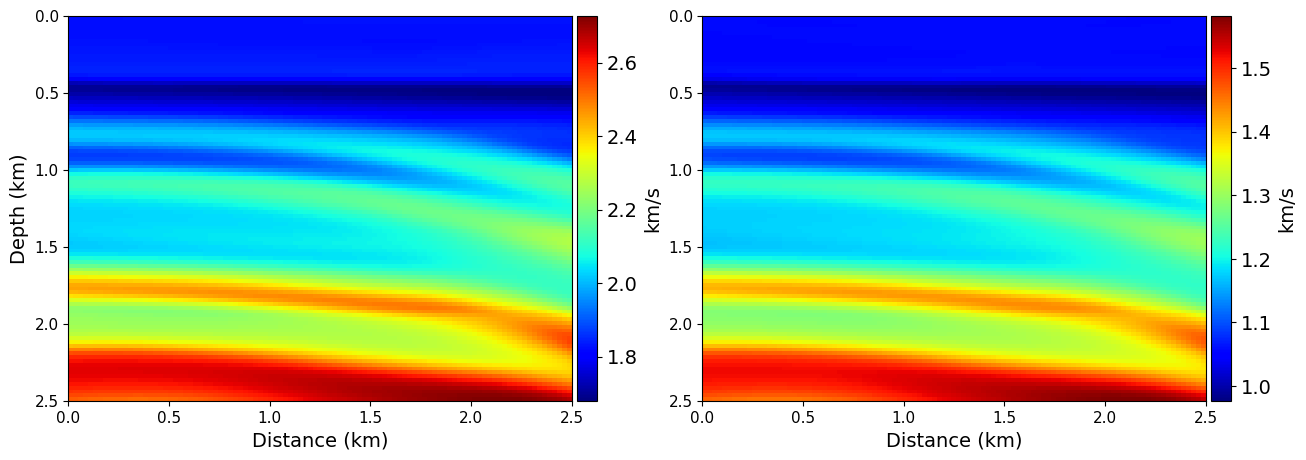

In [ ]:
vp_pred = np.sqrt(alpha_pred).reshape(nz,nx)
vs_pred = np.sqrt(beta_pred).reshape(nz,nx)
scipy.io.savemat('vp_pred.mat', {'vp_pred': vp_pred})
scipy.io.savemat('vs_pred.mat', {'vs_pred': vs_pred})
dx = 0.025
dz = dx
## plot data
plt.style.use('default')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(vp_pred.T,extent=[0,(nx-1)*dx,(nz-1)*dz,0], aspect='auto', cmap="jet")
plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=11)
plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
#cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(vs_pred.T,extent=[0,(nx-1)*dx,(nz-1)*dz,0], aspect='auto', cmap="jet")
plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=11)
#plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
#cbar.mappable.set_clim(2.5,5.5)
cbar.set_label('km/s',size=14)
cbar.ax.tick_params(labelsize=14)